<a href="https://colab.research.google.com/github/manish-anandani/Data-Science-Projects/blob/main/Emotion_Classification_from_Speech_using_Ensemble_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

Build a model to recognize emotion from speech using Ensemble learning

## Learning Objectives

At the end of the mini-project, we will be able to :

* extract the features from audio data
* implement ML classification algorithms individually and as Ensembles, to classify emotions
* record the voice sample and test it with trained model

## Dataset

**TESS Dataset**

The first dataset chosen for this mini-project is the [TESS](https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/E8H2MF) (Toronto emotional speech set) dataset. It contains 2880 files.  A set of 200 target words were spoken in the carrier phrase "Say the word _____' by two actresses and the sets were recorded in seven different emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). Both actresses spoke English as their first language, were university educated, and had musical training. Audiometric testing indicated that both actresses had thresholds within the normal range.

**Ravdess Dataset**

The second dataset chosen for this mini-project is [Ravdess](https://zenodo.org/record/1188976#.YLczy4XivIU) (The Ryerson Audio-Visual Database of Emotional Speech and Song). This dataset contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

**File naming convention**

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

**Filename identifiers**

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: `03-01-06-01-02-01-12.wav`

    - Audio-only - 03
    - Speech - 01
    - Fearful - 06
    - Normal intensity - 01
    - Statement "dogs" - 02
    - 1st Repetition - 01
    - 12th Actor - 12 Female, as the actor ID number is even.

## Information

**Speech Emotion Recognition (SER)** is the task of recognizing the emotion from  speech, irrespective of the semantics. Humans can efficiently perform this task as a natural part of speech communication, however, the ability to conduct it automatically using programmable devices is a field of active research.

Studies of automatic emotion recognition systems aim to create efficient, real-time methods of detecting the emotions of mobile phone users, call center operators and customers, car drivers, pilots, and many other human-machine communication users. Adding emotions to machines forms an important aspect of making machines appear and act in a human-like manner

Lets gain familiarity with some of the audio based features that are commonly used for SER.

**Mel scale** — The mel scale (derived from the word *melody*) is a perceptual scale of pitches judged by listeners to be equal in distance from one another. The reference point between this scale and normal frequency measurement is defined by assigning a perceptual pitch of 1000 mels to a 1000 Hz tone, 40 dB above the listener's threshold. Above about 500 Hz, increasingly large intervals are judged by listeners to produce equal pitch increments. Refer [here](https://towardsdatascience.com/learning-from-audio-the-mel-scale-mel-spectrograms-and-mel-frequency-cepstral-coefficients-f5752b6324a8) for more detailed information.

**Pitch** — how high or low a sound is. It depends on frequency, higher pitch is high frequency

**Frequency** — speed of vibration of sound, measures wave cycles per second

**Chroma** — Representation for audio where spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma). Computed by summing the log frequency magnitude spectrum across octaves.

**Fourier Transforms** — used to convert from time domain to frequency domain. Time domain shows how signal changes over time. Frequency domain shows how much of the signal lies within each given frequency band over a range of frequencies

**Librosa**

[Librosa](https://librosa.org/doc/latest/index.html) is a Python package, built for speech and audio analytics. It provides modular functions that simplify working with audio data and help in achieving a wide range of applications such as identification of the personal characteristics of different individuals' voice samples, detecting emotions from audio samples etc.

For further details on the Librosa package, refer [here](https://conference.scipy.org/proceedings/scipy2015/pdfs/brian_mcfee.pdf).


## Grading = 10 Points

In [1]:
# @title Download the datasets and install packages
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Ravdess_Tess.zip
!unzip -qq Ravdess_Tess.zip
# Install packages
!pip -qq install librosa soundfile
!pip -qq install wavio
print("Datasets downloaded successfully!")

Datasets downloaded successfully!


### Import Neccesary Packages

In [2]:
import librosa
import librosa.display
import soundfile
import os, glob, pickle
import re
import numpy as np
import pandas as pd
import re
import seaborn as sns
import IPython.display as ipd
from matplotlib import pyplot as plt
from datetime import datetime
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
import warnings
warnings.filterwarnings('ignore')
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import VotingClassifier

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier



### Work-Flow

* Load the TESS audio data and extract features and labels

* Load the Ravdess audio data and extract features

* Combine both the audio dataset features

* Train and test the model with TESS + Ravdess Data

* Record the team audio samples and add them to TESS + Ravdess data

* Train and test the model with TESS + Ravdess + Team Recorded (combined) data

* Test each of the models with live audio sample recording.

### Load the Tess data and Ravdess data audio files (1 point)

Hint: `glob.glob`

In [3]:
# Load the wav files for both datasets
wav_files_tess = glob.glob("Tess/*/*.wav")
wav_files_rav = glob.glob("ravdess/*/*.wav")

wav_files = wav_files_tess + wav_files_rav

len(wav_files_tess), len(wav_files_rav), len(wav_files)

(2679, 1168, 3847)

#### Play the sample audio

In [4]:
# Run the audio of a sample file
ipd.Audio("/content/Tess/YAF_surprised/YAF_bar_surprised.wav")

### Data Exploration and Visualization (1 point)

#### Visualize the distribution of all the labels

In [ ]:
# This is done below

#### Visualize sample audio signal using librosa

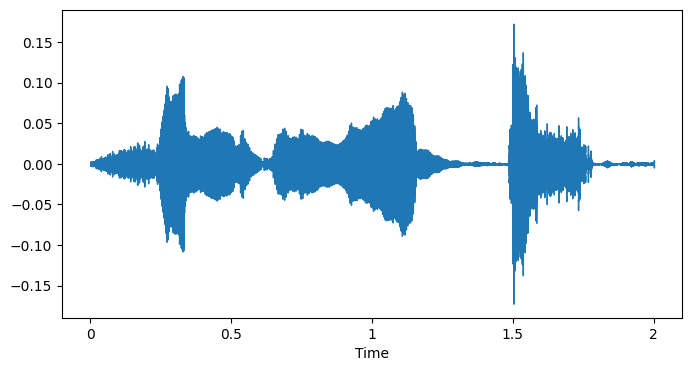

In [5]:
sample_audio_path = '/content/Tess/OAF_happy/OAF_back_happy.wav'

# librosa is used for analyzing and extracting features of an audio signal
data, sampling_rate = librosa.load(sample_audio_path)
plt.figure(figsize=(8, 4))

# librosa.display.waveshow is used to plot waveform of amplitude vs time
librosa.display.waveshow(data, sr=sampling_rate)
plt.show()

### Feature extraction

Read one WAV file at a time using `Librosa`. An audio time series in the form of a 1-dimensional array for mono or 2-dimensional array for stereo, along with time sampling rate (which defines the length of the array), where the elements within each of the arrays represent the amplitude of the sound waves is returned by `librosa.load()` function. Refer to the supplementary notebook ('Audio feature extraction')

To know more about Librosa, explore the [link](https://librosa.org/doc/latest/feature.html)

#### Create a dictionary or a function to encode the emotions

In [43]:
# Emotion encoder for both the datasets

emotions_t = {"angry":0, "disgust":1, "fear":2, "happy":3, "neutral":4, "sad":5, "surprised":6}
emotions_r = {"angry":0, "disgust":1, "fear":2, "happy":3, "neutral":4, "sad":5, "surprised":6}
emotions = {"angry":0, "disgust":1, "fear":2, "happy":3, "neutral":4, "sad":5, "surprised":6}

#### TESS data feature extraction

In [7]:
def extract_feature(file_name):
    # load audio
    X, sample_rate = librosa.load(file_name)
    # print(X.shape)
    # apply stft()
    stft=np.abs(librosa.stft(X))
    # print(stft)
    result=np.array([])
    # compute mfcc
    mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    # print(mfccs, len(mfccs))
    # combine the features
    result=np.hstack((result, mfccs))
    # compute chroma features and combine
    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    # print(chroma, len(chroma))
    result=np.hstack((result, chroma))
    # compute melspectrogram and combine
    mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
    # print(mel, len(mel))
    result=np.hstack((result, mel))
    return result

In [8]:
# Declare list to append features and labels
features_t, labels_t = [], []

for wv_file in wav_files_tess:
  features_t.append(extract_feature(wv_file))
  # extracting label
  emt = wv_file.split("/")[-1].split("_")[-1].split(".")[0]
  labels_t.append(emotions_t[emt])

In [13]:
# array of features and set of labels to check if labels are as expected
features_t_arr = np.array(features_t)
features_t_arr.shape, set(labels_t)

((2679, 180), {0, 1, 2, 3, 4, 5, 6})

In [11]:
# Create a dataframe of features and target and check for null values
cols = ["feature" + str(i) for i in range(1, 181)]

df_features_t = pd.DataFrame(features_t_arr, columns=cols)
df_target_t = pd.DataFrame(labels_t, columns=['target'])

df_tess = pd.concat([df_features_t,df_target_t],axis=1)
df_tess.shape

df_tess.isnull().sum().sum()

0

#### Ravdess data feature extraction

In [12]:
# Declare list to append features and labels and then extract features and labels for the second dataset
features_r, labels_r = [], []

for wv_file in wav_files_rav:
  temp = extract_feature(wv_file)
  # print(temp)
  if (all(element == 0 for element in temp)):
    break
  features_r.append(temp)
  # extracting label
  emt = wv_file.split("/")[-1].split("_")[-1].split(".")[0]
  labels_r.append(emotions_t[emt])

In [14]:
# array of features and set of labels to check if labels are as expected
features_r_arr = np.array(features_r)
features_r_arr.shape, set(labels_r)

((1168, 180), {0, 1, 2, 3, 4, 5, 6})

In [15]:
cols = ["feature" + str(i) for i in range(1, 181)]

df_features_r = pd.DataFrame(features_r_arr, columns=cols)
df_target_r = pd.DataFrame(labels_r, columns=['target'])

df_rav = pd.concat([df_features_r,df_target_r],axis=1)
df_rav.shape

(1168, 181)

#### Save the features

It is best advised to save the features in dataframe and maintain so that feature extraction step is not required to be performed every time.

* Make a DataFrame with features and labels

* Write dataframe into `.CSV` file and save it offline.

In [16]:
df_ad = pd.concat([df_tess,df_rav],axis=0)
csv_file_path = 'audio.csv'
df_ad.to_csv(csv_file_path, index=False)


In [17]:
df_ad.isnull().sum()


feature1      0
feature2      0
feature3      0
feature4      0
feature5      0
             ..
feature177    0
feature178    0
feature179    0
feature180    0
target        0
Length: 181, dtype: int64

#### Visualize the distribution of all the labels

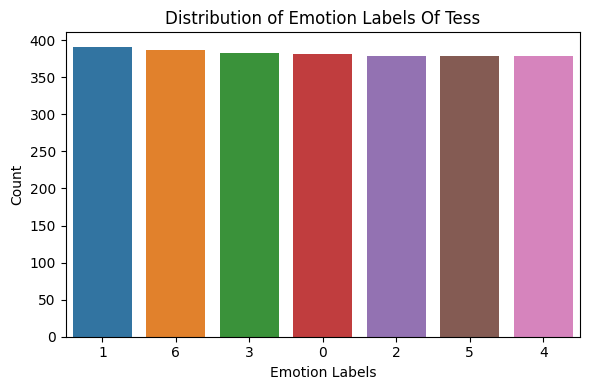

In [18]:
# Create a bar plot using seaborn for tess dataset
plt.figure(figsize=(6, 4))
sns.countplot(data=df_tess, x='target', order=df_tess['target'].value_counts().index)
plt.title('Distribution of Emotion Labels Of Tess')
plt.xlabel('Emotion Labels')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

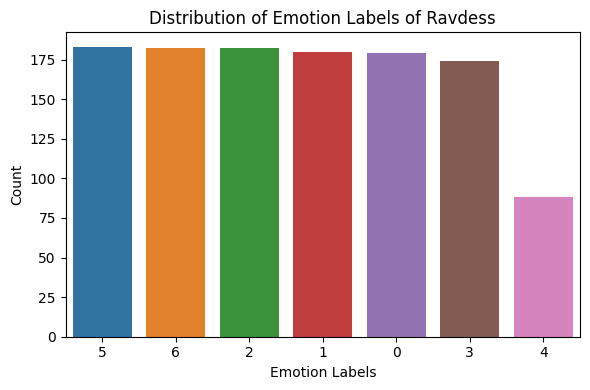

In [20]:
# Create a bar plot using seaborn for Ravdes dataset
plt.figure(figsize=(6, 4))
sns.countplot(data=df_rav, x='target', order=df_rav['target'].value_counts().index)
plt.title('Distribution of Emotion Labels of Ravdess')
plt.xlabel('Emotion Labels')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

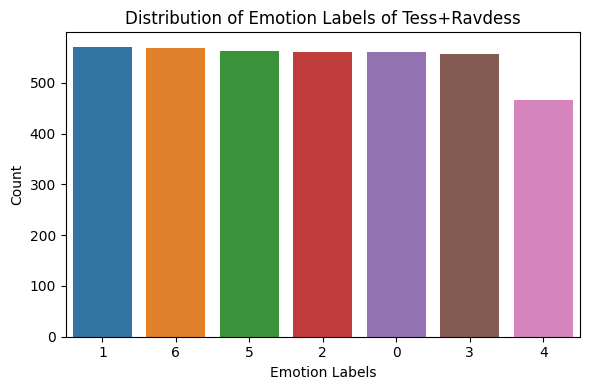

In [21]:
# Create a bar plot using seaborn of the combined dataset
plt.figure(figsize=(6, 4))
sns.countplot(data=df_ad, x='target', order=df_ad['target'].value_counts().index)
plt.title('Distribution of Emotion Labels of Tess+Ravdess')
plt.xlabel('Emotion Labels')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Split the data into train and test

In [22]:
X = df_ad.iloc[:, :-1]
y= df_ad[['target']]

X.shape, y.shape

((3847, 180), (3847, 1))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state= 123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3077, 180), (770, 180), (3077, 1), (770, 1))

In [24]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Train the model with TESS + Ravdess data

* Apply different ML algorithms (eg. DecisionTree, RandomForest, etc.) and find the model with best performance

In [ ]:
# Finding the best parameters for SVM using the RandomizedSearchCV

# from sklearn.model_selection import train_test_split, RandomizedSearchCV

# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))
# }
# svm = SVC()
# random_search = RandomizedSearchCV(svm, param_distributions=param_grid, n_iter=10, scoring='accuracy', cv=5, random_state=42)
# random_search.fit(X_train, y_train)
# print("Best hyperparameters:", random_search.best_params_)

# best_svm = random_search.best_estimator_
# y_pred = best_svm.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Test accuracy:", accuracy)

# svm_clf = SVC(probability= True)
# svm_clf.fit(X_train, y_train)
# y_pred = svm_clf.predict(X_test)
# print(svm_clf.__class__.__name__, accuracy_score(y_test, y_pred))

# Best hyperparameters: {'kernel': 'poly', 'gamma': 0.001, 'C': 1}
# Test accuracy: 0.8274428274428275

In [25]:

svm_clf = SVC(probability= True, kernel='poly', gamma=0.1, C=1)


dt_clf = DecisionTreeClassifier()


rf_clf = RandomForestClassifier(n_estimators=300,           # number of trees in the forest
                                # max_leaf_nodes=16,          # grow trees with max_leaf_nodes, selected by
                                                            # relative reduction in impurity.
                                                            # If None, then unlimited number of leaf nodes
                                random_state= 42
                                )

classifiers = [ ('svc', svm_clf), ('dt_clf',dt_clf), ('rf',rf_clf)]


#### Apply the voting classifier

In [28]:
voting_clf = VotingClassifier(estimators= classifiers, voting='hard')

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
print(voting_clf.__class__.__name__, accuracy_score(y_test, y_pred))

VotingClassifier 0.8675324675324675


### Train the model with TESS + Ravdess + Team recorded data (4 points)

* Record the audio samples (team data), extract features and combine with TESS + Ravdess data features
  - Record and gather all the team data samples with proper naming convention in separate folder

* Train the different ML algorithms and find the model with best performance

#### Load the team data

In [ ]:
# Create a directory

if not os.path.exists('Records/'):
    os.mkdir("Records/")

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
    emt = input("Enter emotion(label) to save the recording: ")
    print("Start speaking!")
    now = datetime.now()
    current_time = now.strftime("%Y-%m-%d_%H-%M-%S")
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    b = b64decode(s.split(',')[1])
    with open('Records/audio_'+current_time+"_"+emt+'.wav','wb') as f:
      f.write(b)
    return 'Records/audio_'+current_time+"_"+emt+'.wav'


In [ ]:
# call the function to record a sample
record()

Enter emotion(label) to save the recording: happy
Start speaking!


<IPython.core.display.Javascript object>

'Records/audio_2023-08-27_09-39-14_happy.wav'

In [ ]:
record_m4a = glob.glob("Records/*.m4a") # Upload available sample records from google drive
record_wav = glob.glob("Records/*.wav")

files_record = record_m4a + record_wav
len(files_record)

26

#### Extracting features of team data and combine with TESS + Ravdess

In [ ]:
from operator import contains
# Declare list to append features and labels
features_record, labels_record = [], []

for file in files_record:
  temp = extract_feature(file)
  if (all(element == 0 for element in temp)):
    break
  features_record.append(temp)
  # extracting label
  if ("m4a") in file:
    parts = file.split("/")[-1].split('.')
    emt_m4a = re.match(r'^[A-Za-z]+', parts[0]).group().lower()
    # print(emt_m4a)
    labels_record.append(emotions_t[emt_m4a])
  elif ("wav") in file:
    emt_wav = file.split("_")[-1].split(".")[0]
    # print(emt_wav)
    labels_record.append(emotions_t[emt_wav])

len(labels_record)


26

In [ ]:
cols_record = ["feature" + str(i) for i in range(1, 181)]
features_record_arr = np.array(features_record)
features_record_arr.shape, set(labels_record)

df_features_record = pd.DataFrame(features_record_arr, columns=cols_record)
df_target_record = pd.DataFrame(labels_record, columns=['target'])

df_record = pd.concat([df_features_record,df_target_record],axis=1)
df_record.shape

(26, 181)

In [ ]:
csv_file_path = 'audio_record.csv'
df_record.to_csv(csv_file_path, index=False)

In [ ]:
# Combine with Tess + RavDess + sample record

df_ad_record = pd.concat([df_ad,df_record],axis=0)



#### Train the different ML algorithms

In [ ]:
X = df_ad_record.iloc[:, :-1]
y= df_ad_record[['target']]

X.shape, y.shape

((3873, 180), (3873, 1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state= 123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3098, 180), (775, 180), (3098, 1), (775, 1))

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# from sklearn.model_selection import train_test_split, RandomizedSearchCV

# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))
# }
# svm = SVC()
# random_search = RandomizedSearchCV(svm, param_distributions=param_grid, n_iter=10, scoring='accuracy', cv=5, random_state=42)
# random_search.fit(X_train, y_train)
# print("Best hyperparameters:", random_search.best_params_)

# best_svm = random_search.best_estimator_
# y_pred = best_svm.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Test accuracy:", accuracy)

# svm_clf = SVC(probability= True)
# svm_clf.fit(X_train, y_train)
# y_pred = svm_clf.predict(X_test)
# print(svm_clf.__class__.__name__, accuracy_score(y_test, y_pred))

# Best hyperparameters: {'kernel': 'poly', 'gamma': 0.001, 'C': 1}
# Test accuracy: 0.8274428274428275

In [29]:
# Fitting for KNN

from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors': np.arange(1, 21)}
knn = KNN()
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_knn = grid_search.best_estimator_
# print(best_knn.n_neighbors, best_knn.n_features_in_, best_knn.n_samples_fit_)

# y_pred = best_knn.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Best k:", best_knn.n_neighbors)
# print("Accuracy:", accuracy)

In [ ]:
# Fit for multiclass Logistic Regression

# param_dist = {
#     'penalty': ['l1', 'l2'],
#     'C': np.logspace(-3, 3, 7),
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# }

# logreg = LogisticRegression(multi_class='multinomial', max_iter=1000)
# random_search = RandomizedSearchCV(logreg, param_distributions=param_dist, n_iter=10, scoring='accuracy', cv=5, random_state=42)
# random_search.fit(X_train, y_train)
# print("Best hyperparameters:", random_search.best_params_)

# best_logreg = random_search.best_estimator_
# y_pred = best_logreg.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Test accuracy:", accuracy)

In [30]:
# Instantiate LogisticRegression, KNN, SVC and VotingClassifier
knn_clf = KNN(best_knn.n_neighbors)
svm_clf = SVC(probability= True, kernel='poly', gamma=0.1, C=1)

sm_clf = LogisticRegression(multi_class='multinomial', # switch to Softmax Regression
                                     solver='lbfgs', # handle multinomial loss, L2 penalty
                                     C=1)

dt_clf = DecisionTreeClassifier()
bag_clf = BaggingClassifier( base_estimator=dt_clf,     # base estimator to fit on random subsets of the dataset
                            n_estimators=300,       # number of base estimators in the ensemble
                            max_samples=300,        # number of samples to draw from X to train each base estimator.
                                                    # If int, then draw max_samples samples.
                                                    # If float, then draw (max_samples * X.shape[0]) samples.
                            bootstrap=True,         # whether samples are drawn with replacement
                            random_state= 42       # seed used by the random number generator to ensure reproducibility
                            )

rf_clf = RandomForestClassifier(n_estimators=300,           # number of trees in the forest
                                # max_leaf_nodes=16,          # grow trees with max_leaf_nodes, selected by
                                                            # relative reduction in impurity.
                                                            # If None, then unlimited number of leaf nodes
                                random_state= 42
                                )


classifiers = [('knn', knn_clf), ('svc', svm_clf), ('dt_bag',bag_clf), ('rf',rf_clf), ('sm',sm_clf)]


voting_clf = VotingClassifier(estimators= classifiers, voting='soft')

for clf in (sm_clf, knn_clf, svm_clf, bag_clf, rf_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


LogisticRegression 0.8103896103896104
KNeighborsClassifier 0.8792207792207792
SVC 0.8701298701298701
BaggingClassifier 0.8
RandomForestClassifier 0.8649350649350649
VotingClassifier 0.8974025974025974


In [31]:
from sklearn.metrics import confusion_matrix, classification_report
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90       104
           1       0.86      0.96      0.91       107
           2       0.94      0.83      0.88       107
           3       0.87      0.84      0.85       107
           4       0.98      0.95      0.97       103
           5       0.85      0.95      0.90       109
           6       0.86      0.90      0.88       133

    accuracy                           0.90       770
   macro avg       0.90      0.90      0.90       770
weighted avg       0.90      0.90      0.90       770



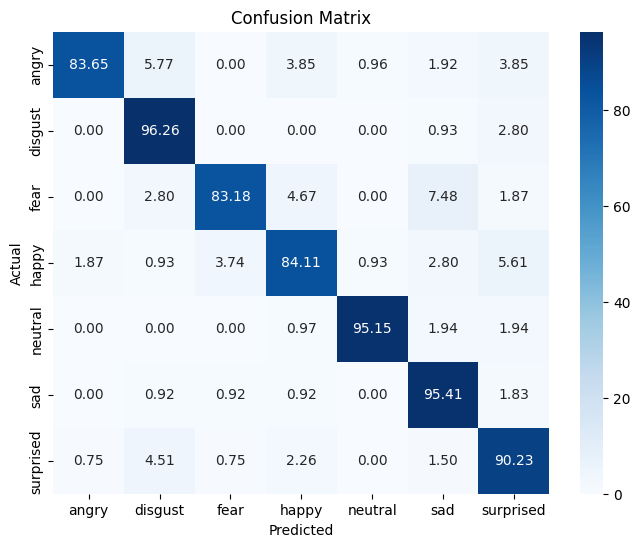

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Normalize the confusion matrix to get percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt= ".2f", cmap="Blues", xticklabels=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad' , 'surprised'], yticklabels=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad' , 'surprised'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Test the best working model with live audio recording

In [33]:
# choose the best working model and assign below
MODEL = clf


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:

wav_files_kt = glob.glob("/content/drive/MyDrive/Colab Notebooks/CDS/Kaggle Competition/Emotion Classification/Kaggle_Testset/*.wav")
wav_files_kt_sorted = []

import glob
folder_path = '/content/drive/MyDrive/Colab Notebooks/CDS/Kaggle Competition/Emotion Classification/Kaggle_Testset'

i=1 # counter to generate the file names - we need sorted files to get the predictions in a sorted order
for file in wav_files_kt:
  target_file = str(i)+".wav" # constructing the name of the file
  i=i+1

# Search the file that matches the name we constructed - if exists then add it to the file list to be processed
  file_paths = glob.glob(os.path.join(folder_path, '**', target_file), recursive=True)
  if file_paths:
    wav_files_kt_sorted.append(file_paths[0])

len(wav_files_kt_sorted)



201

In [38]:
# Declare list to append features - feature extraction
features_kt = []

for wv_file in wav_files_kt_sorted:
  features_kt.append(extract_feature(wv_file))

# Convert the list of arrays into a numpy array
features_kt_arr = np.array(features_kt)
features_kt_arr.shape

(201, 180)

In [39]:
cols = ["feature" + str(i) for i in range(1, 181)]
df_features_kt = pd.DataFrame(features_kt_arr, columns=cols)
df_features_kt.shape

(201, 180)

In [40]:
X_test = df_features_kt
X_test = sc.transform(X_test)
X_test.shape

(201, 180)

In [41]:
y_pred_kt = MODEL.predict(X_test)
y_pred_kt

array([0, 1, 5, 5, 5, 1, 4, 4, 0, 2, 6, 2, 6, 0, 6, 2, 3, 1, 5, 0, 4, 2,
       1, 2, 3, 3, 2, 6, 1, 6, 1, 2, 6, 5, 2, 5, 5, 0, 2, 1, 6, 1, 2, 0,
       0, 4, 5, 3, 3, 2, 4, 5, 1, 6, 6, 2, 0, 0, 5, 1, 4, 4, 3, 4, 0, 5,
       3, 6, 4, 3, 5, 0, 4, 4, 3, 2, 3, 6, 6, 0, 6, 3, 2, 2, 2, 5, 6, 5,
       2, 4, 5, 0, 5, 2, 5, 1, 0, 5, 1, 2, 0, 5, 4, 4, 3, 6, 1, 0, 5, 4,
       6, 5, 0, 4, 1, 5, 0, 2, 4, 5, 2, 5, 2, 3, 0, 4, 1, 6, 4, 1, 6, 5,
       2, 3, 1, 6, 2, 6, 5, 3, 6, 4, 2, 1, 1, 5, 2, 0, 3, 1, 2, 3, 3, 5,
       6, 3, 4, 6, 2, 0, 0, 0, 4, 4, 2, 3, 0, 6, 2, 0, 5, 3, 3, 3, 1, 0,
       4, 1, 0, 3, 2, 4, 6, 4, 4, 4, 6, 4, 3, 3, 2, 1, 0, 1, 4, 3, 4, 4,
       5, 0, 5])

In [44]:
y_pred_kt_index = []
y_pred_kt_label = []

# Below juggling to convert the encoded predictions to actual strings and create a dataframe which is exported to a csv
for i in range(0,len(y_pred_kt)):
  y_pred_kt_index.append(i+1)
  idx_emotion = list(emotions.values()).index(y_pred_kt[i])
  # print(idx_emotion)
  y_pred_kt_label.append(list(emotions.keys())[idx_emotion])

data = {'Id': y_pred_kt_index, 'Label': y_pred_kt_label}
df_kt = pd.DataFrame(data)
df_kt

csv_file_path = 'result.csv'
df_kt.to_csv(csv_file_path, index=False)

In [ ]:
#@title Speak the utterance and test
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

if not os.path.exists('ModelTesting/'):
    os.mkdir("ModelTesting/")
def record(sec=5):
    print("Start speaking!")
    now = datetime.now()
    current_time = now.strftime("%Y-%m-%d_%H-%M-%S")
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    b = b64decode(s.split(',')[1])
    with open('ModelTesting/audio_'+current_time+'.wav','wb') as f:
        f.write(b)
    return 'ModelTesting/audio_'+current_time+'.wav'
test_i = record()
recorded_feature_list = []
recorded_feature_list.append(extract_feature(test_i))
recorded_feature_list = sc.transform(recorded_feature_list)
pred = MODEL.predict(recorded_feature_list)
idx_emotion = list(emotions_t.values()).index(pred[0])
print(list(emotions_t.keys())[idx_emotion])
ipd.Audio(test_i)


Start speaking!


<IPython.core.display.Javascript object>

[0]
angry


### Report Analysis

- Report the accuracy for 10 live samples using the model trained on TESS+Ravdess+Team data
- Discuss with the team mentor regarding deep learnt audio features. Read a related article [here](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8805181).
